
<font color=Grey size=6 face=微软雅黑>**原生爬虫-租房价格分析**</font>

# 数据提取

## 取房源数据，生成Dataframe

In [1]:

from urllib import request
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#定义一个类，用于抓房源
class Spider():     
    """用正则表达式定义抓取内容字符串"""
       
    root_pattern = '<div class="content__list--item--main">([\s\S]*?)</div>'
    way_pattern = 'html">([\s\S]*?)·'
    num_pattern = 'zufang/([\s\S]*?).html'
    name_pattern = '·([\s\S]*?) \d'
    price_pattern = '<em>([\s\S]*?)元/月'
    #district_pattern = '/heping/">([\s\S]*?)</a>'
    area_pattern = '<i>/</i>\s([\s\S]*?)"'
    
    #发送html请求，从网站上抓取想要的数据
    def fetch_content(self):  #URL入口
        r = request.urlopen(web)
        htmls = r.read()
        htmls = str(htmls,encoding = 'utf-8')  #更改编码
        return htmls
    
    

    def analysis(self,htmls):  #将抓取内容转换为列表，列表中每一个元素为字典，目的为方便转换为dataframe
        root_html = re.findall(Spider.root_pattern,htmls)
        anchors=[]
        for html in root_html:
            
            num = re.findall(Spider.num_pattern,html)
            way = re.findall(Spider.way_pattern,html)
            name = re.findall(Spider.name_pattern,html)
            price = re.findall(Spider.price_pattern,html)
            #district = re.findall(Spider.district_pattern,html)
            area = re.findall(Spider.area_pattern,html)
            
            anchor = {'num':num,'way':way,'name':name,'price':price,'area':area}
            anchors.append(anchor)
      
        return anchors
    
    
  
    def refine(self,anchors): #内容精炼
        l = lambda x: { 
             'num':x['num'][0].strip(),
             'way':x['way'][0].strip(),
             'name':x['name'][0].strip()
             ,'price':x['price'][0].replace('</em>','')
            #,'district':x['district'][0].strip()
            ,'area':x['area'][0].strip().replace('<i>/</i>','').replace(' ','').replace('<spanclass=','')
         }
        return map(l,anchors)
    
      
    def go(self):#出口
        htmls = self.fetch_content()
        anchors = self.analysis(htmls)
        anchors = list(self.refine(anchors))
        anchors = pd.DataFrame(anchors)
        anchors = anchors.rename(columns={'num':'House_no.','way':'Rent_way','name':'Name','price':'Price(Yuan/Month)'})
        
        return anchors
    


## 将URL定义为一个列表

In [2]:
#URL中包含南开区和平区河西区房源信息
url_nk = ['https://tj.zu.ke.com/zufang/nankai/']#南开区数据
    
for i in range (1,15):
    i += 1       
    r = 'https://tj.zu.ke.com/zufang/nankai/pg'+ str(i) + '/#contentList'
    url_nk.append(r)

url_hp = ['https://tj.zu.ke.com/zufang/heping/']#和平区数据
for i in range (1,15):
    i += 1       
    r = 'https://tj.zu.ke.com/zufang/heping/pg'+ str(i) + '/#contentList'
    url_hp.append(r)


url_hx = ['https://tj.zu.ke.com/zufang/hexi/']#河西区数据
for i in range (1,15):
    i += 1       
    r = 'https://tj.zu.ke.com/zufang/hexi/pg'+ str(i) + '/#contentList'
    url_hp.append(r)
    
url = url_nk + url_hp + url_hx  #总列表

## 调用方法

In [3]:
dfn = pd.DataFrame()
time = 0

for web in url:
    try:  #因为有不能正常open的URL，故做异常处理
        time += 1
        spider = Spider()#类实例化
        
        if time <=15:
            dfnew = spider.go()#调用类方法返回一个dataframe并赋予给一个新变量
            dfnew['District'] = 'Nankai'
            dfn = pd.concat([dfn, dfnew],ignore_index=True) #将所有遍历的列表组合起来
            
        if time >15 and time <=30:
            dfnew = spider.go()#调用类方法返回一个dataframe并赋予给一个新变量
            dfnew['District'] = 'Heping'
            dfn = pd.concat([dfn, dfnew],ignore_index=True) #将所有遍历的列表组合起来
        
        if time>30:
            dfnew = spider.go()#调用类方法返回一个dataframe并赋予给一个新变量
            dfnew['District'] = 'Hexi'
            dfn = pd.concat([dfn, dfnew],ignore_index=True) #将所有遍历的列表组合起来
            
    except IndexError:
        pass
    continue  

# 数据预处理

## 字段分列

###  Area列

因为area列中包含三类信息，所以将此列分成不同的三列

In [4]:
"""处理字段"""
col_area = []
col_orient = []
col_type = []

for i in dfn['area'] :
    new_column = i.split('\n')
    
    new_column1 = new_column[0][:-1]
    col_area.append(new_column1)
    new_column2 = new_column[1]
    col_orient.append(new_column2)
    new_column3 = new_column[2]
    col_type.append(new_column3)   

    
dfn['house_area(㎡)'] = col_area
dfn['house_orient'] = col_orient
dfn['house_type'] = col_type
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),area,District,house_area(㎡),house_orient,house_type
0,TJ2486230449211310080,整租,颂禹里,1900,43㎡\n南北\n1室1厅1卫,Nankai,43,南北,1室1厅1卫
1,TJ2316221299066159104,合租,雅安西里,1230,9㎡\n北\n2室1厅1卫,Nankai,9,北,2室1厅1卫
2,TJ2379468101143240704,合租,程华里,1200,14㎡\n南\n5室1厅1卫,Nankai,14,南,5室1厅1卫
3,TJ2323856084546093056,合租,昔阳里,1390,9㎡\n北\n2室1厅1卫,Nankai,9,北,2室1厅1卫
4,TJ2379468096864780288,合租,程华里,1300,20㎡\n南\n5室1厅1卫,Nankai,20,南,5室1厅1卫


### house_type列

In [5]:
number_bedroom = []
number_livingroom = []
number_bathroom = []

for i in dfn['house_type'] :
   # new_column = i.split('\d')
    new_column = re.findall('\d',i)
    #print(new_column)
    
    new_column1 = new_column[0]
    number_bedroom.append(new_column1)
    new_column2 = new_column[1]
    number_livingroom.append(new_column2)
    new_column3 = new_column[2]
    number_bathroom.append(new_column3)

    
dfn['num_bedroom'] = number_bedroom
dfn['num_livingroom'] = number_livingroom
dfn['num_bathroom'] = number_bathroom


In [6]:
dfn = dfn.drop(columns = ['area'],axis =1)#将多余的列删除
dfn = dfn.drop(columns = ['house_type'],axis =1)#删除多余行
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom
0,TJ2486230449211310080,整租,颂禹里,1900,Nankai,43,南北,1,1,1
1,TJ2316221299066159104,合租,雅安西里,1230,Nankai,9,北,2,1,1
2,TJ2379468101143240704,合租,程华里,1200,Nankai,14,南,5,1,1
3,TJ2323856084546093056,合租,昔阳里,1390,Nankai,9,北,2,1,1
4,TJ2379468096864780288,合租,程华里,1300,Nankai,20,南,5,1,1


## 字段类型转换

In [7]:
dfn['Price(Yuan/Month)'] = dfn['Price(Yuan/Month)'].apply(int) #将str改为int
dfn['house_area(㎡)'] = dfn['house_area(㎡)'].apply(int)
dfn['num_bedroom'] = dfn['num_bedroom'].apply(int)
dfn['num_livingroom'] = dfn['num_livingroom'].apply(int)
dfn['num_bathroom'] = dfn['num_bathroom'].apply(int)

In [8]:
dfn.describe()

,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom
count,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000
mean,2328.640833,41.96000,1.905833,0.921667,1.058333
std,10738.640978,70.11888,1.150247,0.442373,0.414416
min,601.000000,6.00000,1.000000,0.000000,0.000000
25%,1300.000000,20.00000,1.000000,1.000000,1.000000
50%,1600.000000,35.00000,1.000000,1.000000,1.000000
75%,2100.000000,50.00000,2.000000,1.000000,1.000000
max,366666.000000,2223.00000,9.000000,9.000000,5.000000


In [9]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
House_no.            1200 non-null object
Rent_way             1200 non-null object
Name                 1200 non-null object
Price(Yuan/Month)    1200 non-null int64
District             1200 non-null object
house_area(㎡)        1200 non-null int64
house_orient         1200 non-null object
num_bedroom          1200 non-null int64
num_livingroom       1200 non-null int64
num_bathroom         1200 non-null int64
dtypes: int64(5), object(5)
memory usage: 93.9+ KB


## 处理列内容

### 整理house_orient列

In [10]:
orient = { '东':'East'
          ,'南':'South'
          ,'西':'West'
          ,'北':'North'
          ,'南北':'N-S'
          ,'北南':'N-S'
          ,'东西':'E-W'
          ,'西东':'E-W'
          ,'东南':'Southeast'
          ,'南东':'Southeast'
          ,'西南':'Southwest'
          ,'南西':'Southwest'
          ,'西北':'Northwest'
          ,'北西':'Northwest'
          ,'东北':'Northeast'
          ,'北东':'Northeast'
         }


In [11]:
dfn['house_orient'].value_counts()#观察异常值

南        610
南北       138
北        125
东        100
西         68
东南        49
东西        33
西南        21
西北        20
东北        11
           9
南西         5
东南南        3
东南西北北      1
东南西北       1
东西南西       1
西北北        1
东东南西北      1
东南北        1
东东北        1
东南南北       1
Name: house_orient, dtype: int64

In [12]:
dfn['house_direct'] = dfn['house_orient'].map(orient) #将房子朝向映射成英文字符串
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom,house_direct
0,TJ2486230449211310080,整租,颂禹里,1900,Nankai,43,南北,1,1,1,N-S
1,TJ2316221299066159104,合租,雅安西里,1230,Nankai,9,北,2,1,1,North
2,TJ2379468101143240704,合租,程华里,1200,Nankai,14,南,5,1,1,South
3,TJ2323856084546093056,合租,昔阳里,1390,Nankai,9,北,2,1,1,North
4,TJ2379468096864780288,合租,程华里,1300,Nankai,20,南,5,1,1,South


In [13]:
dfn.drop('house_orient',axis=1,inplace=True)
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),num_bedroom,num_livingroom,num_bathroom,house_direct
0,TJ2486230449211310080,整租,颂禹里,1900,Nankai,43,1,1,1,N-S
1,TJ2316221299066159104,合租,雅安西里,1230,Nankai,9,2,1,1,North
2,TJ2379468101143240704,合租,程华里,1200,Nankai,14,5,1,1,South
3,TJ2323856084546093056,合租,昔阳里,1390,Nankai,9,2,1,1,North
4,TJ2379468096864780288,合租,程华里,1300,Nankai,20,5,1,1,South


### 整理rent_way列

In [14]:
rent_way = {'整租':'Entire','合租':'Joint'}#映射字段内容将中文内容改成中文
dfn['Rent_way'] = dfn['Rent_way'].map(rent_way) 
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),num_bedroom,num_livingroom,num_bathroom,house_direct
0,TJ2486230449211310080,Entire,颂禹里,1900,Nankai,43,1,1,1,N-S
1,TJ2316221299066159104,Joint,雅安西里,1230,Nankai,9,2,1,1,North
2,TJ2379468101143240704,Joint,程华里,1200,Nankai,14,5,1,1,South
3,TJ2323856084546093056,Joint,昔阳里,1390,Nankai,9,2,1,1,North
4,TJ2379468096864780288,Joint,程华里,1300,Nankai,20,5,1,1,South


In [15]:
dfn['house_direct'].value_counts()

South        610
N-S          138
North        125
East         100
West          68
Southeast     49
E-W           33
Southwest     26
Northwest     20
Northeast     11
Name: house_direct, dtype: int64

## 查找空值

In [16]:
dfn[dfn.isnull().T.any()]  #查找空值

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),num_bedroom,num_livingroom,num_bathroom,house_direct
118,TJ2621563069293674496,Entire,居华里,2550,Nankai,103,2,2,2,NaN
286,TJ2356256679470825472,Entire,昌宁北里,1500,Nankai,35,2,0,1,NaN
535,TJ2608547061087879168,Entire,乐昌里,2500,Heping,57,2,1,1,NaN
537,TJ2611569543792820224,Entire,华润紫阳里,4698,Heping,79,2,1,1,NaN
538,TJ2611571712105922560,Entire,华润紫阳里,4698,Heping,79,2,1,1,NaN
539,TJ2607983651404644352,Entire,乐昌里,2800,Heping,57,2,1,1,NaN
543,TJ2613593523961995264,Entire,乐昌里,2500,Heping,60,2,1,1,NaN
598,TJ2613593523961995264,Entire,乐昌里,2500,Heping,60,2,1,1,NaN
612,TJ2472512171766972416,Entire,同庆后,2100,Heping,46,2,1,1,NaN
615,TJ2376707028468383744,Entire,诚基经贸中心,2350,Heping,55,1,1,1,NaN


In [17]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
House_no.            1200 non-null object
Rent_way             1200 non-null object
Name                 1200 non-null object
Price(Yuan/Month)    1200 non-null int64
District             1200 non-null object
house_area(㎡)        1200 non-null int64
num_bedroom          1200 non-null int64
num_livingroom       1200 non-null int64
num_bathroom         1200 non-null int64
house_direct         1180 non-null object
dtypes: int64(5), object(5)
memory usage: 93.9+ KB


可见house_direct列有空值，故将空值用此列出现最多的类作为填充。

In [18]:
dfn['house_direct'].fillna('South', inplace=True) #填充空值

In [19]:
dfn['house_direct'].value_counts() #查看出租房屋及卧室朝向,看是否还有其他异常值

South        630
N-S          138
North        125
East         100
West          68
Southeast     49
E-W           33
Southwest     26
Northwest     20
Northeast     11
Name: house_direct, dtype: int64

In [20]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
House_no.            1200 non-null object
Rent_way             1200 non-null object
Name                 1200 non-null object
Price(Yuan/Month)    1200 non-null int64
District             1200 non-null object
house_area(㎡)        1200 non-null int64
num_bedroom          1200 non-null int64
num_livingroom       1200 non-null int64
num_bathroom         1200 non-null int64
house_direct         1200 non-null object
dtypes: int64(5), object(5)
memory usage: 93.9+ KB


# 探索性分析

## 区域与价格的关系

In [21]:
dfn.describe()

,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom
count,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000
mean,2328.640833,41.96000,1.905833,0.921667,1.058333
std,10738.640978,70.11888,1.150247,0.442373,0.414416
min,601.000000,6.00000,1.000000,0.000000,0.000000
25%,1300.000000,20.00000,1.000000,1.000000,1.000000
50%,1600.000000,35.00000,1.000000,1.000000,1.000000
75%,2100.000000,50.00000,2.000000,1.000000,1.000000
max,366666.000000,2223.00000,9.000000,9.000000,5.000000


观察异常值，价格与平米数列很大，排序查看异常值

In [22]:
dfn.sort_values("Price(Yuan/Month)",inplace=False,ascending=False)

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),num_bedroom,num_livingroom,num_bathroom,house_direct
789,TJ2557249699170230272,Entire,睦南道,366666,Heping,2223,9,9,3,South
797,TJ2153687133716480000,Entire,泰安道五大院,50000,Heping,260,5,3,2,N-S
785,TJ2560703227678949376,Entire,保利大都会天汇茗苑,30000,Heping,390,4,2,3,South
793,TJ2533947301459148800,Entire,招商津湾天玺,16800,Heping,239,4,2,3,Southwest
805,TJ2094788415324160000,Entire,环球金融中心津门公寓,15000,Heping,216,3,1,2,N-S
794,TJ2530193272903565312,Entire,赛顿大厦,15000,Heping,240,4,2,3,N-S
796,TJ2485468389339045888,Entire,招商津湾天玺,15000,Heping,181,3,2,2,Southeast
776,TJ2566533513763627008,Entire,招商津湾天玺,13800,Heping,209,3,1,2,South
786,TJ2553457989541969920,Entire,贵都大厦,12000,Heping,188,4,2,2,N-S
809,TJ2310130535118143488,Entire,卫津路,12000,Heping,253,1,1,1,N-S


In [23]:
dfn = dfn.drop(index =dfn[dfn['Price(Yuan/Month)']==366666].index)

In [24]:
#dfn['Price(Yuan/Month)'] = dfn['Price(Yuan/Month)'].apply(int) #将str改为int
#dfn['house_area(㎡)'] = dfn['house_area(㎡)'].apply(int)
dfn.groupby(['District','Rent_way']).mean()#均值

Price(Yuan/Month)  house_area(㎡)  num_bedroom  \
District Rent_way                                                  
Heping   Entire          3332.487805      58.902439     1.439024   
         Joint           1662.774194      18.032258     3.419355   
Hexi     Entire          1592.878327      40.749049     1.250951   
         Joint           1221.811024      16.417323     3.346457   
Nankai   Entire          1857.401434      46.114695     1.318996   
         Joint           1115.725146      15.099415     3.380117   

                   num_livingroom  num_bathroom  
District Rent_way                                
Heping   Entire          0.850610      1.003049  
         Joint           1.064516      1.483871  
Hexi     Entire          0.920152      0.946768  
         Joint           0.937008      1.314961  
Nankai   Entire          0.946237      0.989247  
         Joint           0.935673      1.169591

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


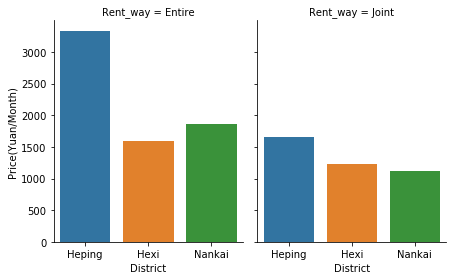

In [25]:
# plt.rcParams['font.sans-serif']=['SimHei']
# # 用来正常显示负号
# plt.rcParams['axes.unicode_minus']=False
a = dfn.groupby(['District','Rent_way']).mean()#均值
a = a.reset_index()#重置索引
sns.catplot(x="District",y='Price(Yuan/Month)',col='Rent_way',data = a,kind = 'bar',height= 4,aspect=0.8)#分类型数据绘图
plt.show()

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0, flags=flags)


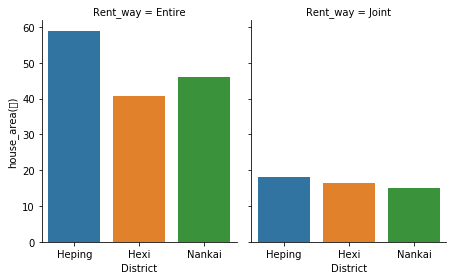

In [26]:
# plt.rcParams['font.sans-serif']=['SimHei']
# # 用来正常显示负号
# plt.rcParams['axes.unicode_minus']=False
a = dfn.groupby(['District','Rent_way']).mean()#均值
a = a.reset_index()#重置索引
sns.catplot(x="District",y='house_area(㎡)',col='Rent_way',data = a,kind = 'bar',height= 4,aspect=0.8)#分类型数据绘图
plt.show()

在合租上河西区和南开区均价几乎持平，和平区略高，平米数相差无几，南开区合租房卧室最小；整租上和平区明显高出其它区，在均价高的基础上，平米数大的房子出租的也多，租价也更高，南开区的出租房的平米数和都要略高与河西区。

## 房屋朝向与价格的关系

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

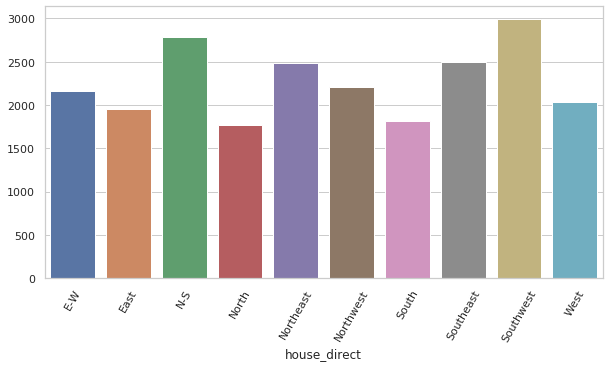

In [27]:
#不同朝向的房子的均价
col = ['house_direct','Price(Yuan/Month)']
df1 = dfn[col]
#df1 = pd.DataFrame(
df1= df1.groupby('house_direct')['Price(Yuan/Month)'].mean()
#sns.heatmap(df1)
plt.figure(figsize = (10,5))
sns.set(style="whitegrid")
sns.barplot(x=df1.index,y=df1.values)
plt.xticks(rotation = 60)

## 价格区间分箱

In [28]:
dfn['price'] = pd.cut(dfn['Price(Yuan/Month)'],[0,800,1000,1200,1500,2000,3000,4000,5000,10000,50000,100000])
#dfn[dfn['Price(Yuan/Month)']>4000] 

In [29]:
dfn['price'].value_counts()

(1500, 2000]       334
(1200, 1500]       298
(2000, 3000]       190
(1000, 1200]       102
(800, 1000]         82
(3000, 4000]        69
(0, 800]            55
(4000, 5000]        49
(10000, 50000]      10
(5000, 10000]       10
(50000, 100000]      0
Name: price, dtype: int64

## 描述性统计

### 分布情况

In [30]:
dfn['District'].value_counts()#各个区的样本数量不一样

Nankai    450
Hexi      390
Heping    359
Name: District, dtype: int64

In [31]:
b = dfn.groupby(['District']).skew()#偏态系数
b

,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom
District,,,,,
Heping,8.822062,3.163317,1.929554,-0.060613,0.580625
Hexi,5.045531,1.762089,0.987394,-3.257323,2.305091
Nankai,5.015301,2.439028,0.749354,-1.198491,1.890707


In [32]:
a = dfn.groupby(['District','Rent_way']).skew()#偏态系数
a.reset_index()

,District,Rent_way,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom
0,Heping,Entire,8.578764,3.229202,1.729363,-0.036731,0.654260
1,Heping,Joint,-0.215183,3.088872,-0.262238,0.955160,-0.510944
2,Hexi,Entire,5.923277,3.084135,1.403492,-3.117906,-2.549808
3,Hexi,Joint,-0.117540,3.482227,-0.203023,-3.640673,2.194634
4,Nankai,Entire,5.209683,3.473048,1.518470,-1.344408,-1.694927
5,Nankai,Joint,0.033168,6.256293,-0.165580,-1.015800,1.776524


In [33]:
dfn['Rent_way'].value_counts()

Entire    870
Joint     329
Name: Rent_way, dtype: int64

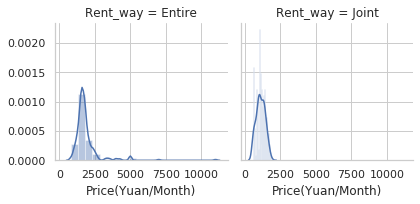

In [34]:
#南开区价格频率分布
dfhp = dfn[dfn['District'] == 'Nankai'][['District','Rent_way','Price(Yuan/Month)']]
j = sns.FacetGrid(dfhp,col='Rent_way')
j.map(sns.distplot,'Price(Yuan/Month)',bins=20)

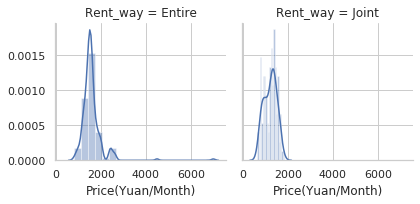

In [35]:
#河西区价格频率分布
dfhp = dfn[dfn['District'] == 'Hexi'][['District','Rent_way','Price(Yuan/Month)']]
j = sns.FacetGrid(dfhp,col='Rent_way')
j.map(sns.distplot,'Price(Yuan/Month)',bins=20)

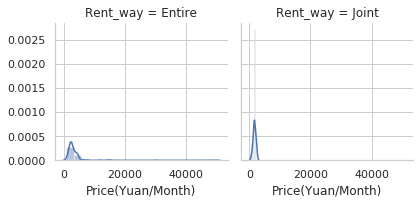

In [36]:
#h和平区价格频率分布
dfhp = dfn[dfn['District'] == 'Heping'][['District','Rent_way','Price(Yuan/Month)']]
j = sns.FacetGrid(dfhp,col='Rent_way')
j.map(sns.distplot,'Price(Yuan/Month)',bins=20)

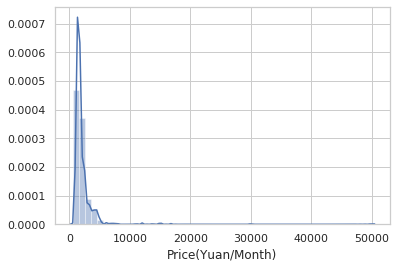

In [37]:
#dfprice = dfn.drop('house_direct',axis=1,inplace=True)
sns.distplot(dfn['Price(Yuan/Month)'])

### 房屋朝向占比

In [38]:
orient_count = dfn['house_direct'].value_counts() #查看出租房屋及卧室朝向,可见朝向为南的房子出租数量较多
orient_count

South        629
N-S          138
North        125
East         100
West          68
Southeast     49
E-W           33
Southwest     26
Northwest     20
Northeast     11
Name: house_direct, dtype: int64

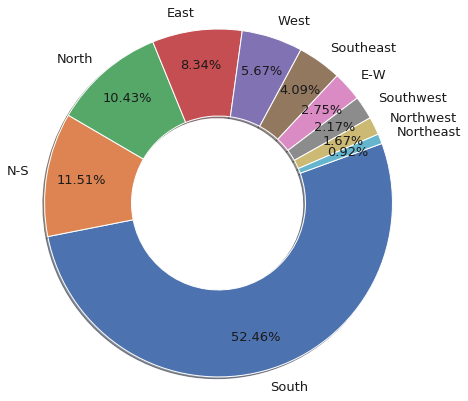

In [39]:
#不同朝向的房子占总体样本的比例
%matplotlib inline
explode = (0,0,0,0,0,0,0,0,0,0.15,0)
plt.pie(orient_count, labels = orient_count.index,radius=2,autopct='%3.2f%%',textprops={'fontsize':13,'color':'k'}
        #,explode = explode
        ,shadow=True,startangle=20,pctdistance = 0.8,
       counterclock = False, wedgeprops = {'width' : 1}
       )

#pctdistance
plt.show()

#         counterclock = False, wedgeprops = {'width' : 0.4})

# 特征工程

## 特征提取one-hot encoder 

### District列

In [40]:
districtDf = pd.get_dummies(dfn['District'] , prefix='Dis-' )
districtDf.head()

,Dis-_Heping,Dis-_Hexi,Dis-_Nankai
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [41]:
#添加one-hot编码产生的虚拟变量（dummy variables）到数据集full
dfn = pd.concat([dfn,districtDf],axis=1)
dfn.drop('District',axis=1,inplace=True)
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom,house_direct,price,Dis-_Heping,Dis-_Hexi,Dis-_Nankai
0,TJ2486230449211310080,Entire,颂禹里,1900,43,1,1,1,N-S,"(1500, 2000]",0,0,1
1,TJ2316221299066159104,Joint,雅安西里,1230,9,2,1,1,North,"(1200, 1500]",0,0,1
2,TJ2379468101143240704,Joint,程华里,1200,14,5,1,1,South,"(1000, 1200]",0,0,1
3,TJ2323856084546093056,Joint,昔阳里,1390,9,2,1,1,North,"(1200, 1500]",0,0,1
4,TJ2379468096864780288,Joint,程华里,1300,20,5,1,1,South,"(1200, 1500]",0,0,1


In [42]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199 entries, 0 to 1199
Data columns (total 13 columns):
House_no.            1199 non-null object
Rent_way             1199 non-null object
Name                 1199 non-null object
Price(Yuan/Month)    1199 non-null int64
house_area(㎡)        1199 non-null int64
num_bedroom          1199 non-null int64
num_livingroom       1199 non-null int64
num_bathroom         1199 non-null int64
house_direct         1199 non-null object
price                1199 non-null category
Dis-_Heping          1199 non-null uint8
Dis-_Hexi            1199 non-null uint8
Dis-_Nankai          1199 non-null uint8
dtypes: category(1), int64(5), object(4), uint8(3)
memory usage: 98.8+ KB


### Rent_way列

In [43]:
rentDf = pd.get_dummies(dfn['Rent_way'] , prefix='Way-' )
rentDf.head()

#dfn = dfn.drop(columns = ['area'],axis =1)#将多余的列删除


,Way-_Entire,Way-_Joint
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


In [44]:
dfn = pd.concat([dfn,rentDf],axis=1)
dfn.drop('Rent_way',axis=1,inplace=True)
dfn.head()

,House_no.,Name,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom,house_direct,price,Dis-_Heping,Dis-_Hexi,Dis-_Nankai,Way-_Entire,Way-_Joint
0,TJ2486230449211310080,颂禹里,1900,43,1,1,1,N-S,"(1500, 2000]",0,0,1,1,0
1,TJ2316221299066159104,雅安西里,1230,9,2,1,1,North,"(1200, 1500]",0,0,1,0,1
2,TJ2379468101143240704,程华里,1200,14,5,1,1,South,"(1000, 1200]",0,0,1,0,1
3,TJ2323856084546093056,昔阳里,1390,9,2,1,1,North,"(1200, 1500]",0,0,1,0,1
4,TJ2379468096864780288,程华里,1300,20,5,1,1,South,"(1200, 1500]",0,0,1,0,1


### house_direct列

In [45]:
directDf = pd.get_dummies(dfn['house_direct'] , prefix='direct-' )
directDf.head()

,direct-_E-W,direct-_East,direct-_N-S,direct-_North,direct-_Northeast,direct-_Northwest,direct-_South,direct-_Southeast,direct-_Southwest,direct-_West
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [46]:
dfn = pd.concat([dfn,directDf],axis=1)
dfn.drop('house_direct',axis=1,inplace=True)
dfn.head()

,House_no.,Name,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom,price,Dis-_Heping,Dis-_Hexi,...,direct-_E-W,direct-_East,direct-_N-S,direct-_North,direct-_Northeast,direct-_Northwest,direct-_South,direct-_Southeast,direct-_Southwest,direct-_West
0,TJ2486230449211310080,颂禹里,1900,43,1,1,1,"(1500, 2000]",0,0,...,0,0,1,0,0,0,0,0,0,0
1,TJ2316221299066159104,雅安西里,1230,9,2,1,1,"(1200, 1500]",0,0,...,0,0,0,1,0,0,0,0,0,0
2,TJ2379468101143240704,程华里,1200,14,5,1,1,"(1000, 1200]",0,0,...,0,0,0,0,0,0,1,0,0,0
3,TJ2323856084546093056,昔阳里,1390,9,2,1,1,"(1200, 1500]",0,0,...,0,0,0,1,0,0,0,0,0,0
4,TJ2379468096864780288,程华里,1300,20,5,1,1,"(1200, 1500]",0,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
dfn = dfn.drop(index =dfn[dfn['Price(Yuan/Month)']==366666].index)

In [48]:
dfn.drop('House_no.',axis=1,inplace=True)
dfn.head()

,Name,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom,price,Dis-_Heping,Dis-_Hexi,Dis-_Nankai,...,direct-_E-W,direct-_East,direct-_N-S,direct-_North,direct-_Northeast,direct-_Northwest,direct-_South,direct-_Southeast,direct-_Southwest,direct-_West
0,颂禹里,1900,43,1,1,1,"(1500, 2000]",0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,雅安西里,1230,9,2,1,1,"(1200, 1500]",0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,程华里,1200,14,5,1,1,"(1000, 1200]",0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,昔阳里,1390,9,2,1,1,"(1200, 1500]",0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,程华里,1300,20,5,1,1,"(1200, 1500]",0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [49]:
dfn.drop('Name',axis=1,inplace=True)
dfn.drop('price',axis=1,inplace=True)

dfn.head()

,Price(Yuan/Month),house_area(㎡),num_bedroom,num_livingroom,num_bathroom,Dis-_Heping,Dis-_Hexi,Dis-_Nankai,Way-_Entire,Way-_Joint,direct-_E-W,direct-_East,direct-_N-S,direct-_North,direct-_Northeast,direct-_Northwest,direct-_South,direct-_Southeast,direct-_Southwest,direct-_West
0,1900,43,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0
1,1230,9,2,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,1200,14,5,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
3,1390,9,2,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
4,1300,20,5,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


### 相关性 

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/opt/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0, flags=flags)


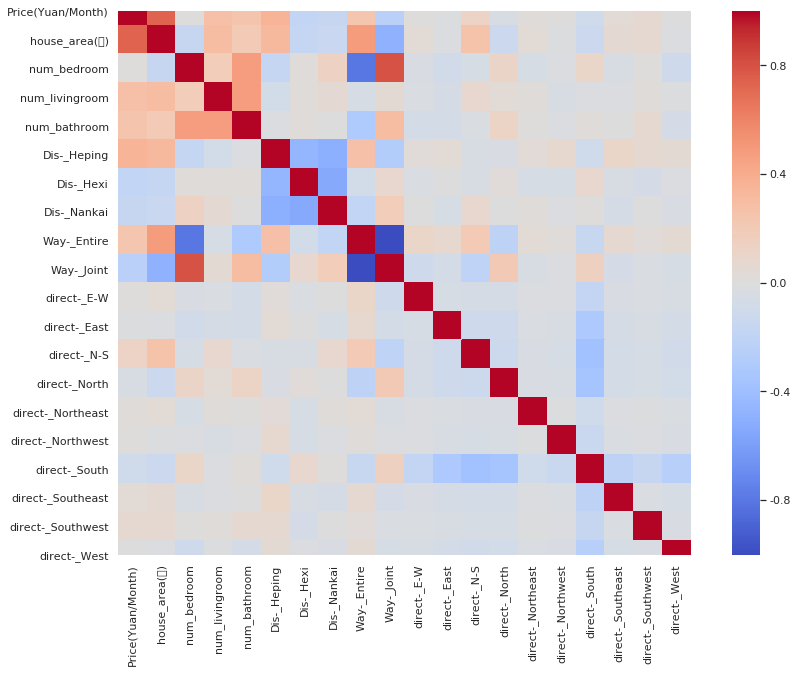

In [50]:
%pylab inline
# 设置图幅大小
pylab.rcParams['figure.figsize'] = (15, 10)
# 计算相关系数
corrmatrix = dfn.corr()
# 绘制热力图，热力图横纵坐标分别是data的index/column,vmax/vmin设置热力图颜色标识上下限，center显示颜色标识中心位置，cmap颜色标识颜色设置
sns.heatmap(corrmatrix,square=True,vmax=1,vmin=-1,center=0.0,cmap='coolwarm')

# 建模预测

## 建立训练集和测试集

In [51]:
X=dfn.iloc[:,1:]
y=dfn['Price(Yuan/Month)']

In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test  = train_test_split(X,y)

## 多元线性回归

In [53]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()#实例化模型

In [54]:
lin_reg.fit(x_train,y_train)# 拟合训练集

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
lin_reg.coef_

array([  52.85459791,  109.49535469,  391.62538579,  -65.8410798 ,
        540.87429427, -269.75265971, -271.12163455, -311.43123921,
        311.43123921,   41.13676178,   40.0897366 , -136.4675291 ,
         97.5987825 , -159.21721547,  127.36812485, -110.78717558,
       -215.59261132,  111.50770758,  204.36341815])

In [56]:
lin_reg.intercept_

-357.02110116628387

In [57]:
lin_reg.score(x_test,y_test)

0.680229413305985

## KNN

### 实例化分类器，拟合训练集，观测模型评分

In [58]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
knn_reg.fit(x_train,y_train)
knn_reg.score(x_test,y_test)

0.7719298431987078

### 数据归一化

In [59]:
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler()
std_scaler.fit(x_train)   #进行内部拟合，内部参数会发生变化
x_train1 = std_scaler.transform(x_train)
x_train1

array([[ 0.36403617, -0.79883941,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [ 0.12885707, -0.79883941,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [ 0.22964811, -0.79883941,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       ...,
       [-0.87905337,  0.95276213,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [ 0.39763319,  0.07696136,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [-0.94624739,  0.95276213,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086]])

In [60]:
x_test1 = std_scaler.transform(x_test)

In [61]:
x_test1

array([[-0.64387426, -0.79883941,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [-0.54308322, -0.79883941,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [-0.07272502, -0.79883941,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       ...,
       [ 0.39763319,  0.07696136,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [-0.97984441,  0.95276213,  0.24772183, ..., -0.20126912,
        -0.15465444, -0.23487086],
       [-0.07272502, -0.79883941, -2.37230086, ..., -0.20126912,
        -0.15465444, -0.23487086]])

### 观测模型的评分

In [62]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(x_train1,y_train)
knn_reg.score(x_test1,y_test)

0.76294551973123

### 预测值与测试值的对比

In [63]:
y_predict = knn_reg.predict(x_test1)#预测值

In [64]:
import matplotlib
import seaborn
import matplotlib.pyplot as plot

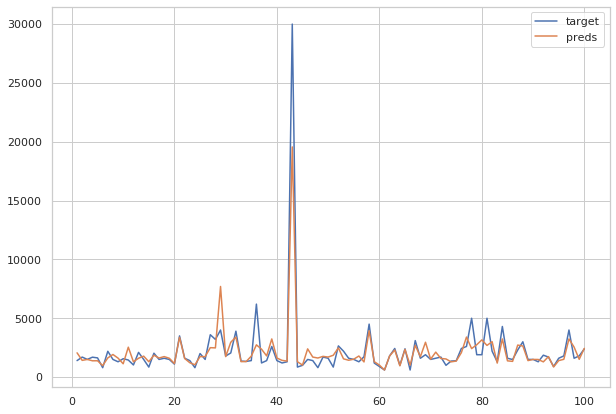

In [65]:
plot.figure(figsize=(10,7))       #画布大小
num=100
x=np.arange(1,num+1)             
plot.plot(x,y_test[:num],label='target')      #目标取值
plot.plot(x,y_predict[:num],label='preds')        #预测取值
plot.legend(loc='upper right')  #线条显示位置
plot.show()